<a href="https://colab.research.google.com/github/Nandha1510/Household-power-consumption-ml-model/blob/main/household_power_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-8377d474e28d>:19: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv("/content/sample_data/household_power_consumption.csv", sep=';', na_values='?', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True)
<ipython-input-2-8377d474e28d>:19: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv("/content/sample_data/household_power_consumption.csv", sep=';', na_values='?', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True)
<ipython-input-2-8377d474e28d>:19: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=Tr


Statistical Summary:
       Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25% 

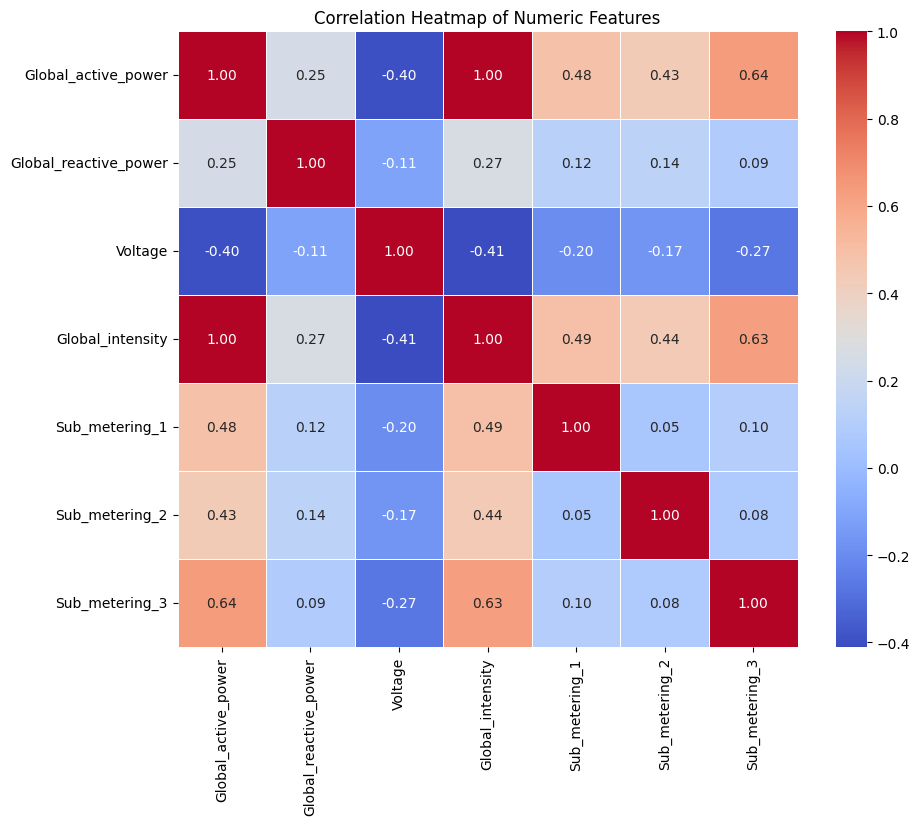

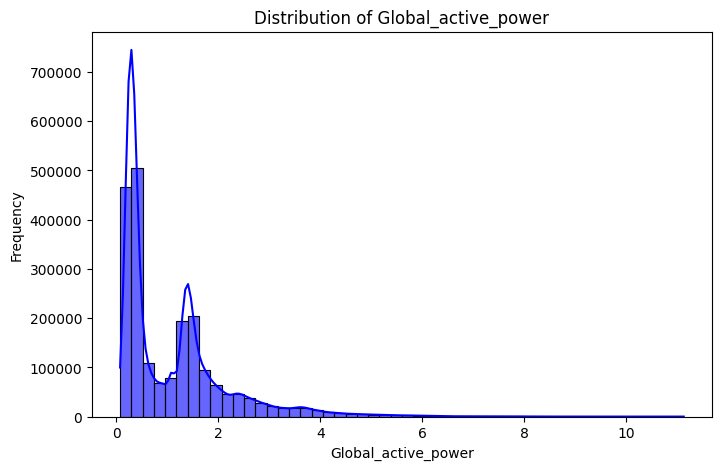

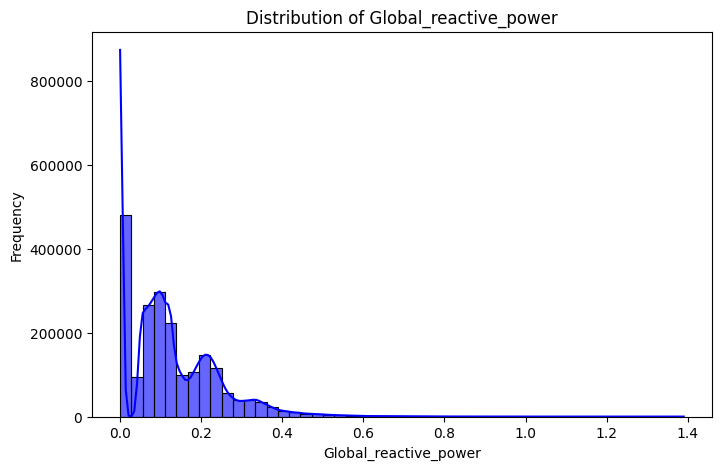

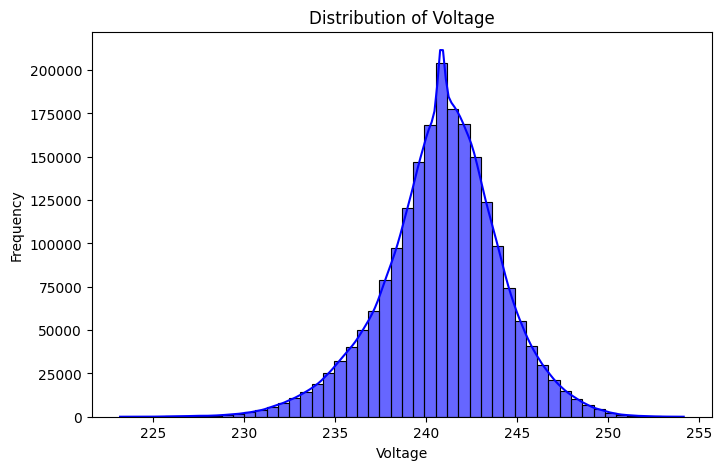

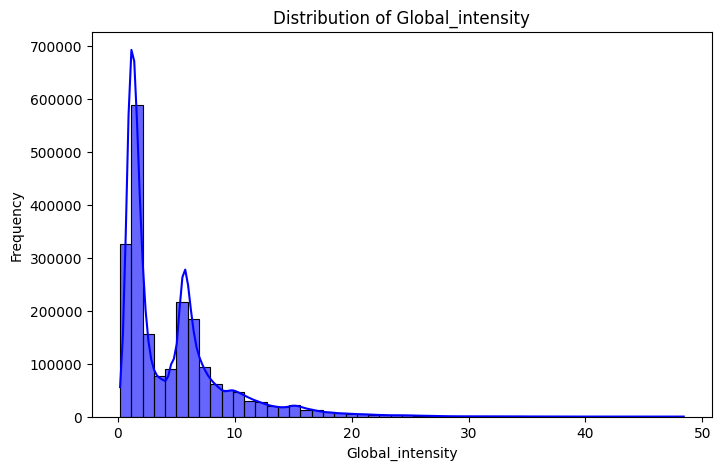

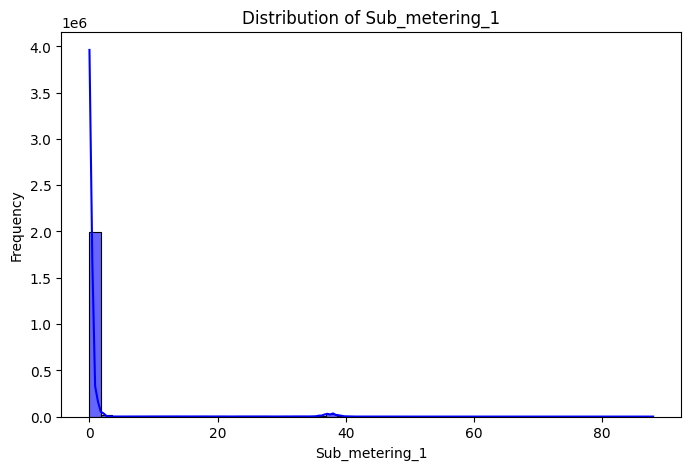

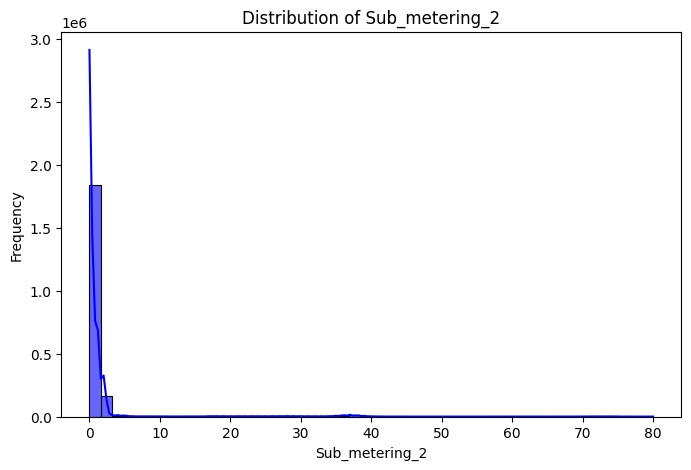

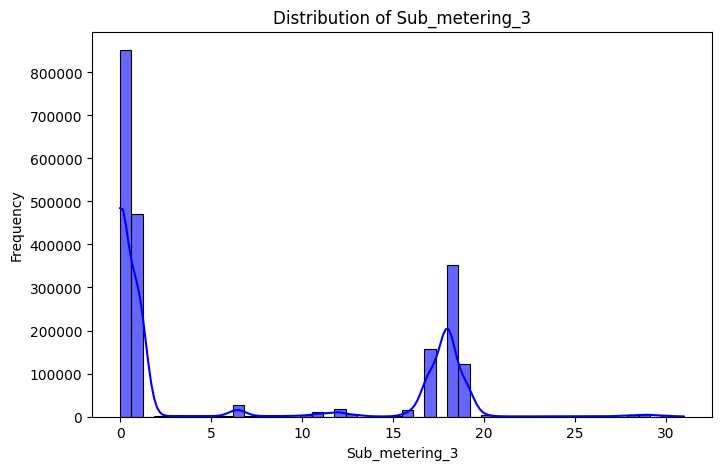

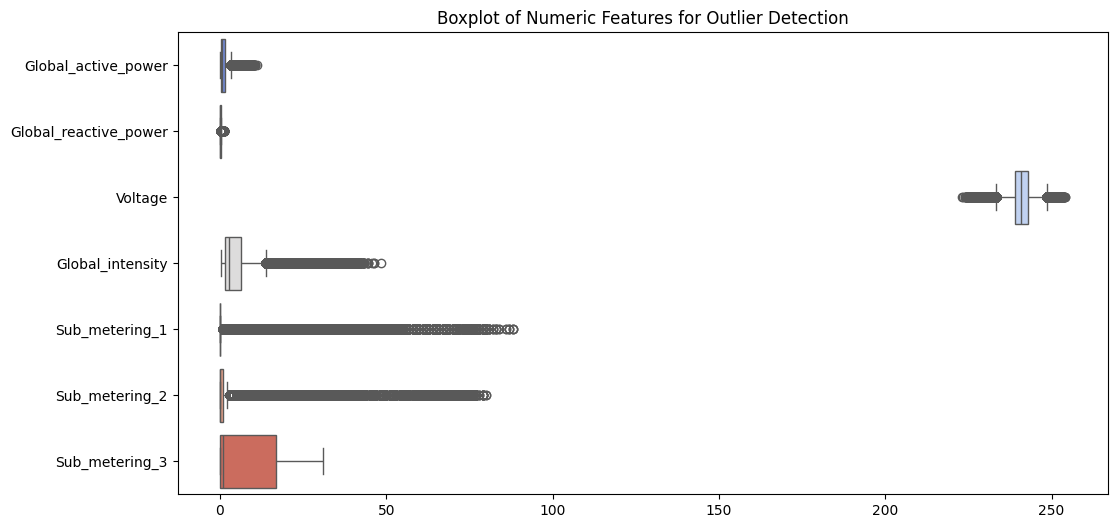

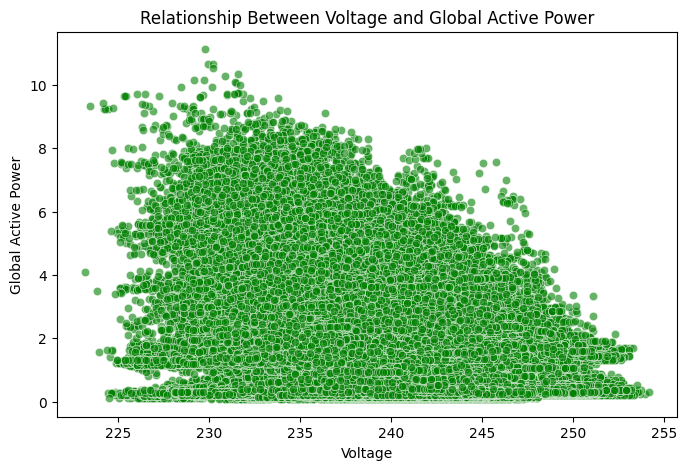

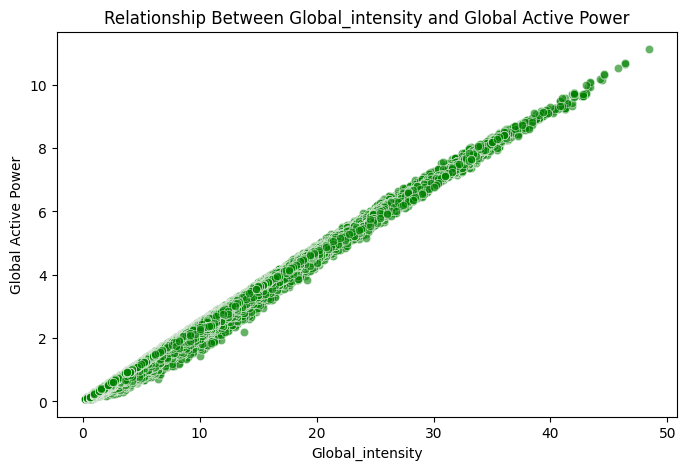

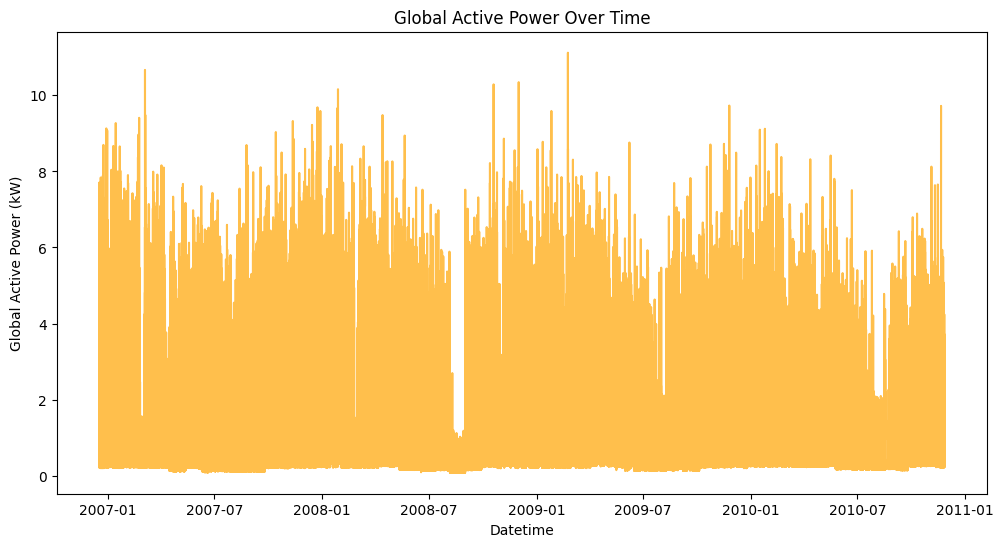

<ipython-input-2-8377d474e28d>:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_avg.index, y=hourly_avg.values, palette='viridis')


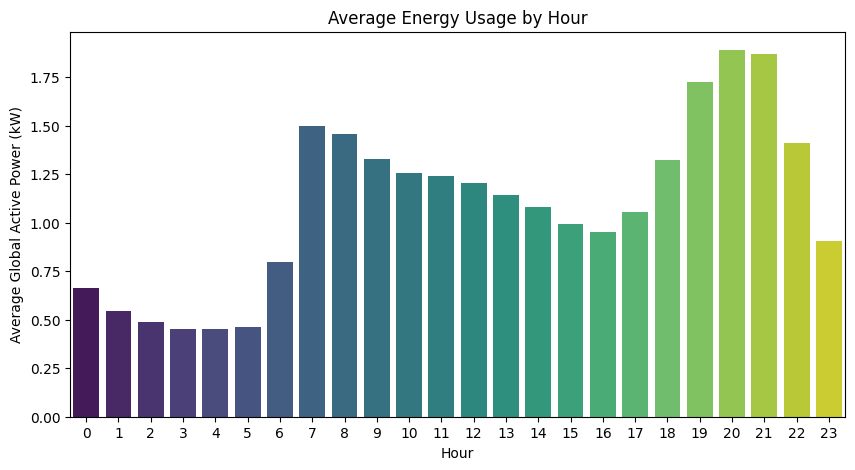

<ipython-input-2-8377d474e28d>:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette='plasma')


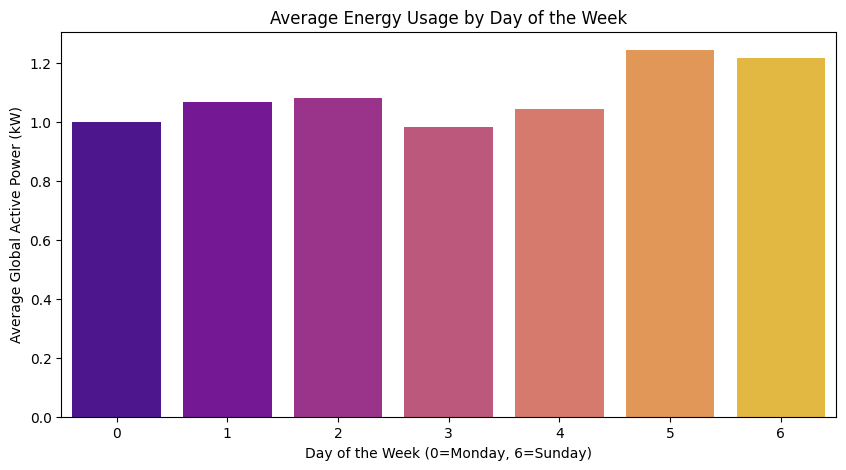

<ipython-input-2-8377d474e28d>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='peak_hour', y='Global_active_power', data=data, palette='Set2')


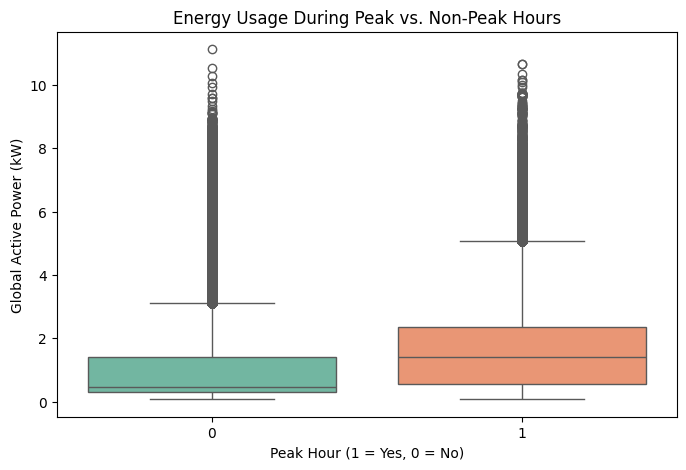

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import IsolationForest
from scipy.stats import uniform, randint

# Load the dataset
data = pd.read_csv("/content/sample_data/household_power_consumption.csv", sep=';', na_values='?', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True)

#Statistical summary
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
                'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
print("\nStatistical Summary:")
print(data[numeric_cols].describe())

#Handling Missing Values
print("\nMissing Values Before Imputation:")
print(data[numeric_cols].isnull().sum())
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.fillna(data.mean(), inplace=True)
print("\nMissing Values After Imputation:")
print(data[numeric_cols].isnull().sum())

# Parse datetime and create additional features(Feauture Engineering)
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek
data['month'] = data['datetime'].dt.month
data['rolling_avg'] = data['Global_active_power'].rolling(window=24, min_periods=1).mean()
data['daily_avg'] = data.groupby(data['datetime'].dt.date)['Global_active_power'].transform('mean')
data['peak_hour'] = data['hour'].apply(lambda x: 1 if 18 <= x <= 22 else 0)

#Exploratory Data Analysis(EDA)
# Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# Visualizing Distributions
for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[col], kde=True, bins=50, color='blue', alpha=0.6)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Boxplots for Outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[numeric_cols], orient='h', palette='coolwarm')
plt.title('Boxplot of Numeric Features for Outlier Detection')
plt.show()

# Relationship Between Global Active Power and Other Features
for col in ['Voltage', 'Global_intensity']:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=data[col], y=data['Global_active_power'], alpha=0.6, color='green')
    plt.title(f'Relationship Between {col} and Global Active Power')
    plt.xlabel(col)
    plt.ylabel('Global Active Power')
    plt.show()

# Time-Series Visualization
plt.figure(figsize=(12, 6))
plt.plot(data['datetime'], data['Global_active_power'], color='orange', alpha=0.7)
plt.title('Global Active Power Over Time')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.show()

# Average Energy Usage by Hour
plt.figure(figsize=(10, 5))
hourly_avg = data.groupby(data['datetime'].dt.hour)['Global_active_power'].mean()
sns.barplot(x=hourly_avg.index, y=hourly_avg.values, palette='viridis')
plt.title('Average Energy Usage by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Global Active Power (kW)')
plt.show()

# Energy Usage by Day of the Week
plt.figure(figsize=(10, 5))
weekday_avg = data.groupby('day_of_week')['Global_active_power'].mean()
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette='plasma')
plt.title('Average Energy Usage by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Global Active Power (kW)')
plt.show()

# Energy Usage During Peak vs. Non-Peak Hours
plt.figure(figsize=(8, 5))
sns.boxplot(x='peak_hour', y='Global_active_power', data=data, palette='Set2')
plt.title('Energy Usage During Peak vs. Non-Peak Hours')
plt.xlabel('Peak Hour (1 = Yes, 0 = No)')
plt.ylabel('Global Active Power (kW)')
plt.show()

# Outlier Detection and Removal using Isolation Forest
isolation_forest = IsolationForest(contamination=0.01, random_state=42)
outliers = isolation_forest.fit_predict(data[numeric_cols])
data['Outlier'] = outliers
data_cleaned = data[data['Outlier'] == 1].drop('Outlier', axis=1)

# Prepare features and target
features = ['Global_intensity', 'Voltage', 'hour', 'day_of_week', 'month', 'rolling_avg', 'daily_avg', 'peak_hour']
X = data_cleaned[features]
y = data_cleaned['Global_active_power']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale data for models requiring scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Linear Regression (Baseline Model)
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_lr = linear_model.predict(X_test_scaled)

# 2. Random Forest with RandomizedSearchCV
rf_model = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 20)
}
rf_random = RandomizedSearchCV(rf_model, rf_params, cv=3, n_iter=10, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# 3. Gradient Boosting (XGBoost) with RandomizedSearchCV
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_params = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2)
}
xgb_random = RandomizedSearchCV(xgb_model, xgb_params, cv=3, n_iter=10, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
xgb_random.fit(X_train, y_train)
best_xgb = xgb_random.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# 4. Neural Network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
nn_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=0)
y_pred_nn = nn_model.predict(X_test_scaled).flatten()

# Evaluate Models
def evaluate_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Feature Importance for Tree-Based Models
plt.figure(figsize=(5, 3))
rf_importances = pd.Series(best_rf.feature_importances_, index=features).sort_values(ascending=False)
xgb_importances = pd.Series(best_xgb.feature_importances_, index=features).sort_values(ascending=False)
rf_importances.plot(kind='bar', color='blue', alpha=0.6, label='Random Forest', position=0)
xgb_importances.plot(kind='bar', color='green', alpha=0.6, label='XGBoost', position=1)
plt.title('Feature Importance')
plt.legend()
plt.show()

print("\nModel Evaluation Results:")
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_nn, "Neural Network")


In [3]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import IsolationForest
from scipy.stats import uniform, randint

In [4]:
# Load the dataset
data = pd.read_csv("/content/household_power_consumption.csv", sep=';', na_values='?', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True)

<ipython-input-4-d45d5f831647>:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv("/content/household_power_consumption.csv", sep=';', na_values='?', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True)
<ipython-input-4-d45d5f831647>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv("/content/household_power_consumption.csv", sep=';', na_values='?', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True)
<ipython-input-4-d45d5f831647>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to 

In [5]:
#Statistical summary
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
                'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
print("\nStatistical Summary:")
print(data[numeric_cols].describe())


Statistical Summary:
       Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25% 

In [6]:
#Handling Missing Values
print("\nMissing Values Before Imputation:")
print(data[numeric_cols].isnull().sum())
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.fillna(data.mean(), inplace=True)
print("\nMissing Values After Imputation:")
print(data[numeric_cols].isnull().sum())


Missing Values Before Imputation:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Missing Values After Imputation:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [7]:
# Parse datetime and create additional features(Feauture Engineering)
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek
data['month'] = data['datetime'].dt.month
data['rolling_avg'] = data['Global_active_power'].rolling(window=24, min_periods=1).mean()
data['daily_avg'] = data.groupby(data['datetime'].dt.date)['Global_active_power'].transform('mean')
data['peak_hour'] = data['hour'].apply(lambda x: 1 if 18 <= x <= 22 else 0)

In [8]:
# Display the first few rows with new features
print(data[['datetime', 'hour', 'day_of_week', 'month', 'rolling_avg', 'daily_avg', 'peak_hour']].head())


             datetime  hour  day_of_week  month  rolling_avg  daily_avg  \
0 2006-12-16 17:24:00    17            5     12     4.216000   3.053475   
1 2006-12-16 17:25:00    17            5     12     4.788000   3.053475   
2 2006-12-16 17:26:00    17            5     12     4.983333   3.053475   
3 2006-12-16 17:27:00    17            5     12     5.084500   3.053475   
4 2006-12-16 17:28:00    17            5     12     4.800800   3.053475   

   peak_hour  
0          0  
1          0  
2          0  
3          0  
4          0  


In [ ]:
#Exploratory Data Analysis(EDA)

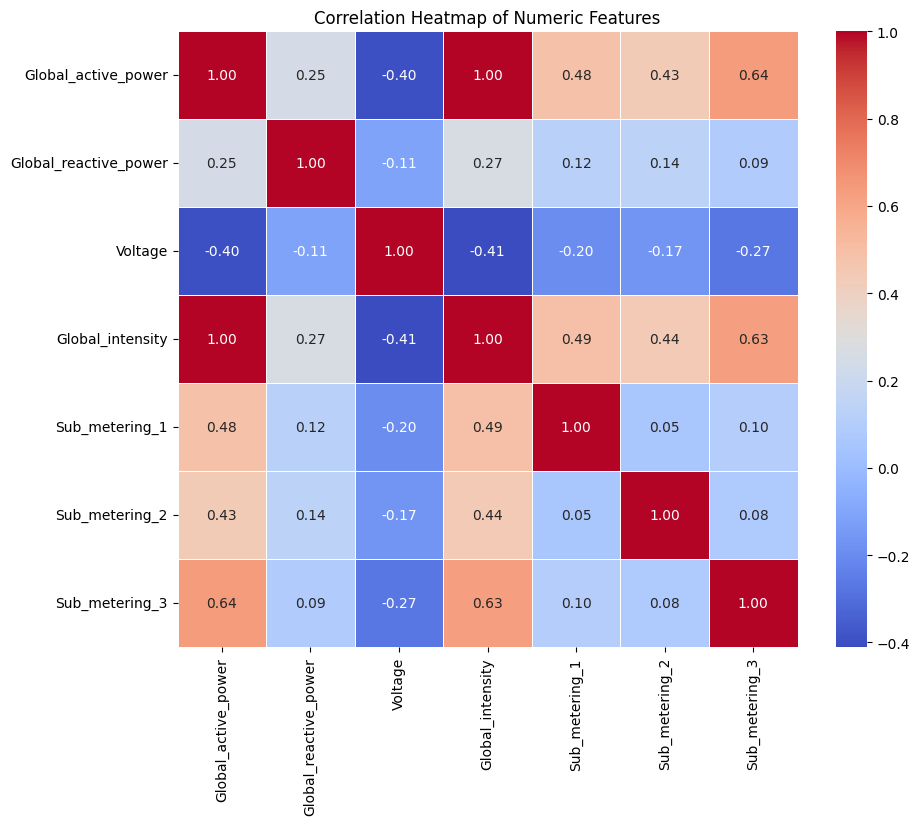

In [17]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

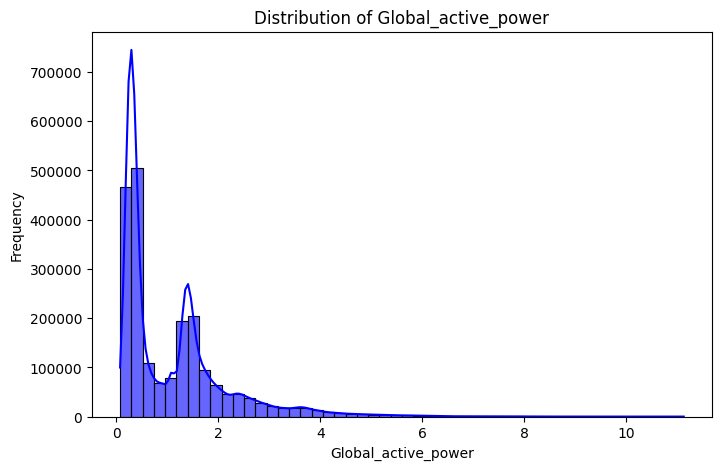

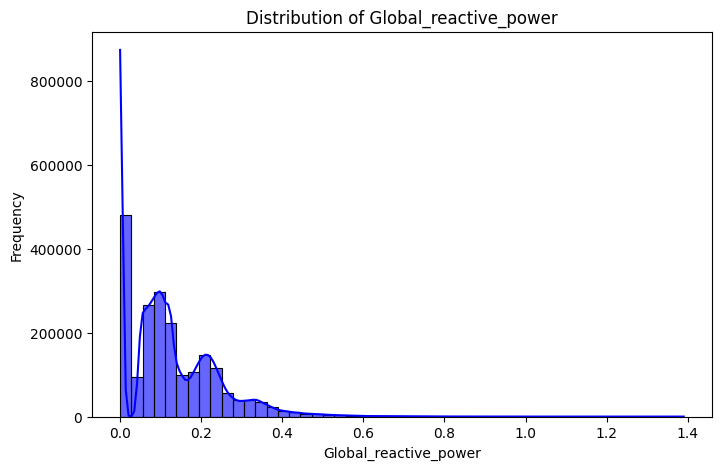

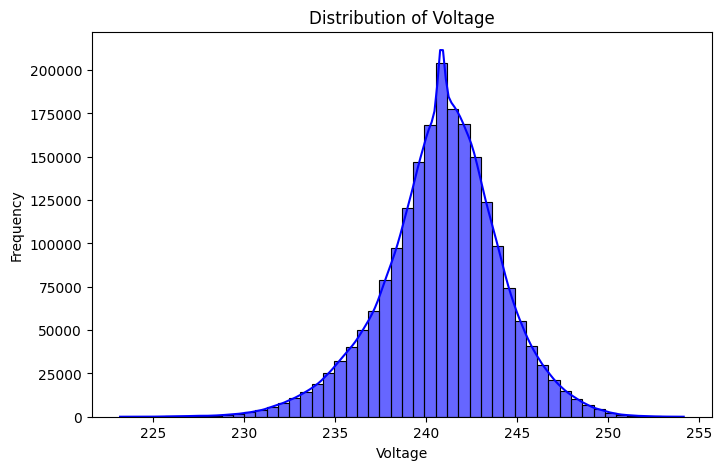

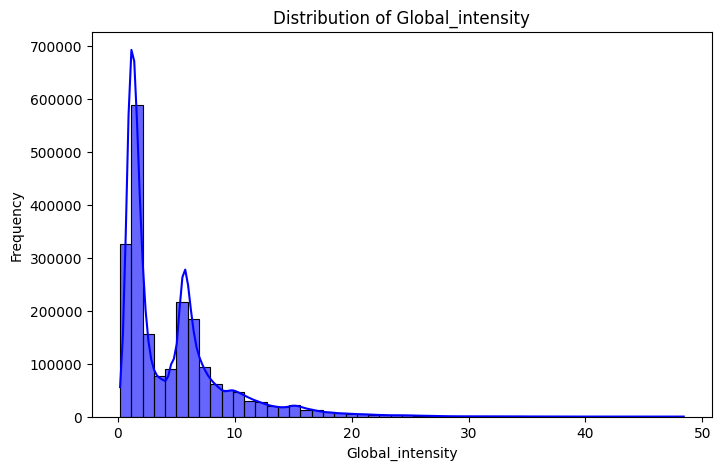

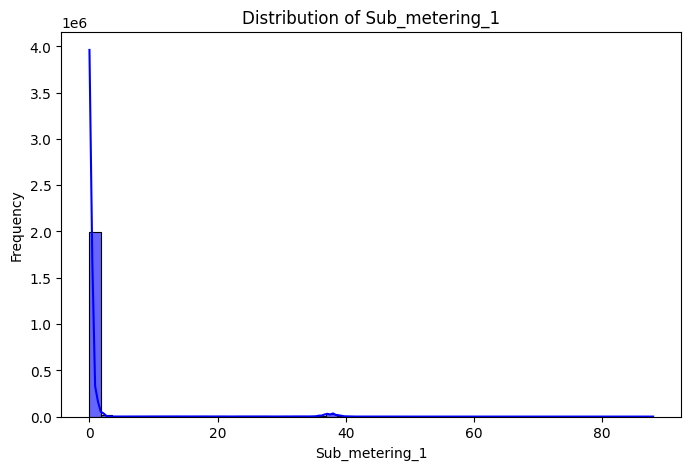

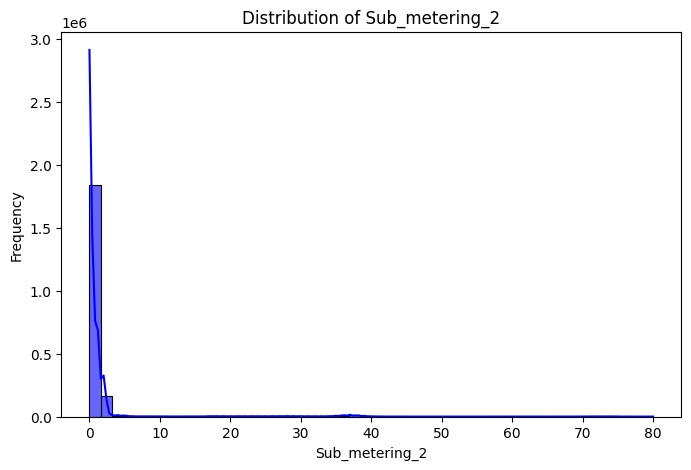

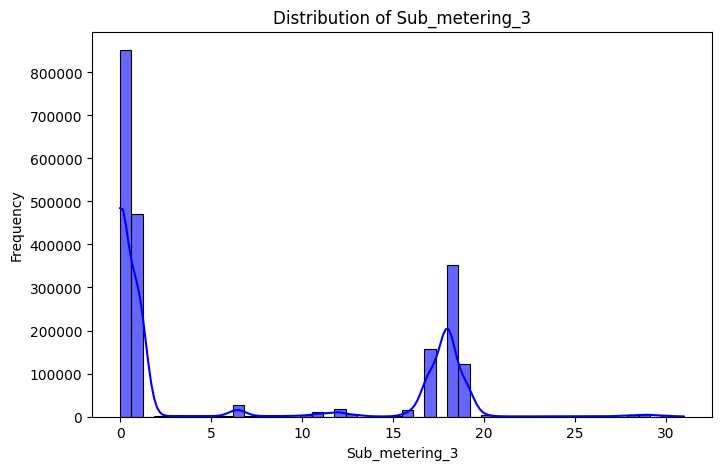

In [18]:
# Visualizing Distributions
for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[col], kde=True, bins=50, color='blue', alpha=0.6)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

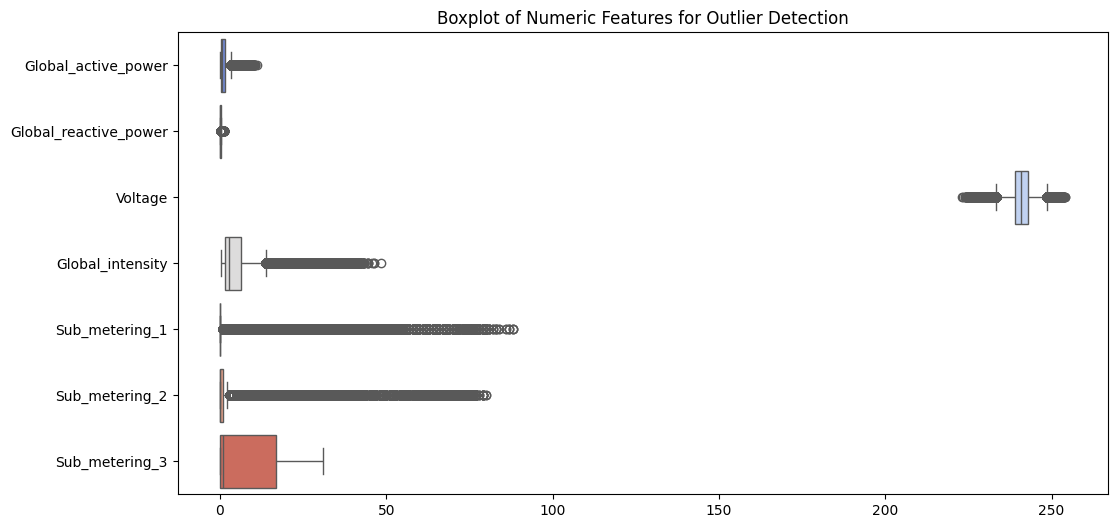

In [19]:
# Boxplots for Outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[numeric_cols], orient='h', palette='coolwarm')
plt.title('Boxplot of Numeric Features for Outlier Detection')
plt.show()

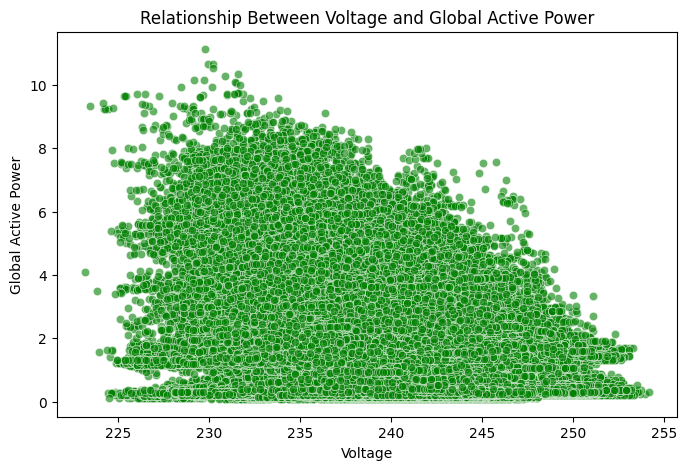

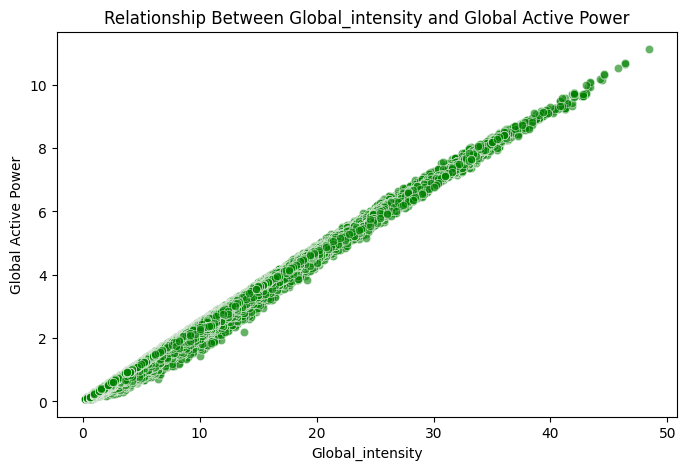

In [9]:
# Relationship Between Global Active Power and Other Features
for col in ['Voltage', 'Global_intensity']:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=data[col], y=data['Global_active_power'], alpha=0.6, color='green')
    plt.title(f'Relationship Between {col} and Global Active Power')
    plt.xlabel(col)
    plt.ylabel('Global Active Power')
    plt.show()

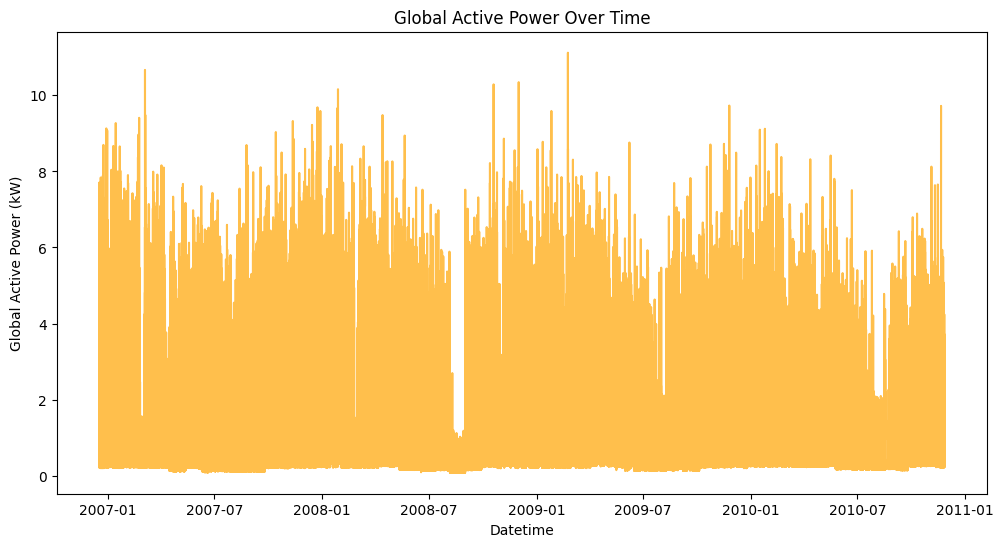

In [20]:
# Time-Series Visualization
plt.figure(figsize=(12, 6))
plt.plot(data['datetime'], data['Global_active_power'], color='orange', alpha=0.7)
plt.title('Global Active Power Over Time')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.show()

<ipython-input-21-ddaa77c9860e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_avg.index, y=hourly_avg.values, palette='viridis')


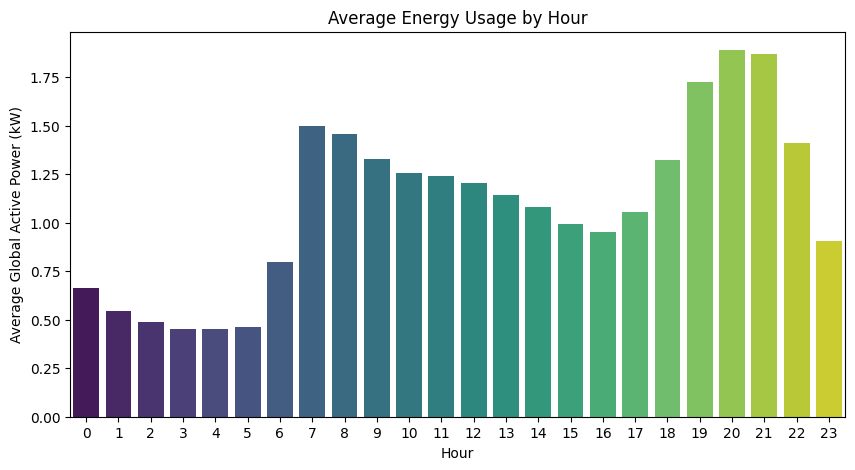

In [21]:
# Average Energy Usage by Hour
plt.figure(figsize=(10, 5))
hourly_avg = data.groupby(data['datetime'].dt.hour)['Global_active_power'].mean()
sns.barplot(x=hourly_avg.index, y=hourly_avg.values, palette='viridis')
plt.title('Average Energy Usage by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Global Active Power (kW)')
plt.show()

<ipython-input-22-0456f72caea0>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette='plasma')


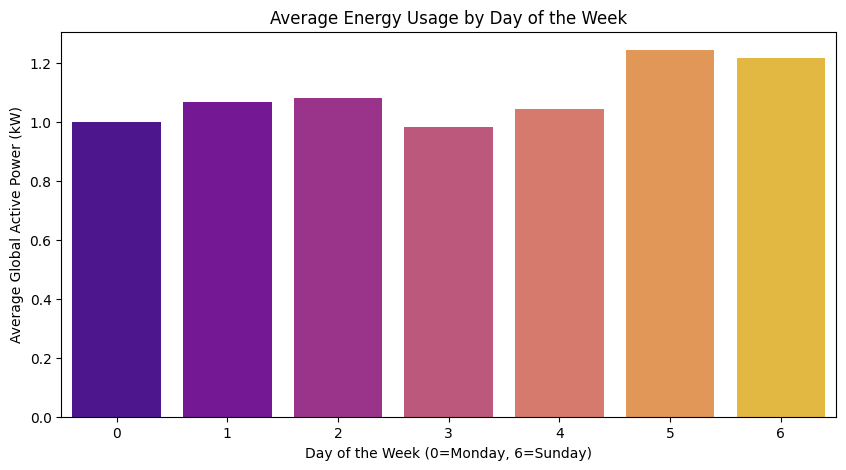

In [22]:
# Energy Usage by Day of the Week
plt.figure(figsize=(10, 5))
weekday_avg = data.groupby('day_of_week')['Global_active_power'].mean()
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette='plasma')
plt.title('Average Energy Usage by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Global Active Power (kW)')
plt.show()

<ipython-input-23-96a268975574>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='peak_hour', y='Global_active_power', data=data, palette='Set2')


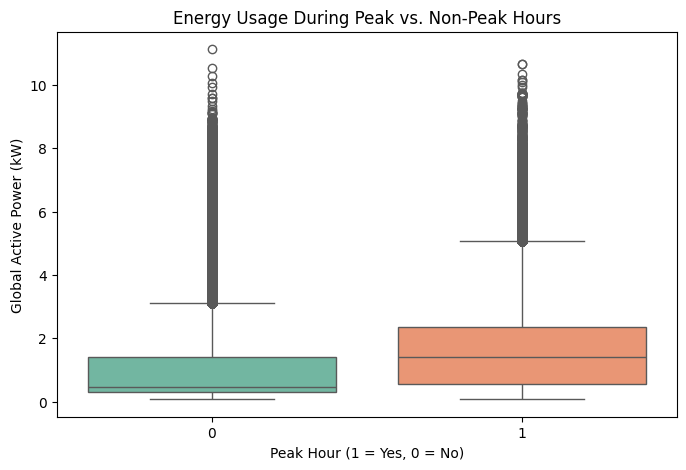

In [23]:
# Energy Usage During Peak vs. Non-Peak Hours
plt.figure(figsize=(8, 5))
sns.boxplot(x='peak_hour', y='Global_active_power', data=data, palette='Set2')
plt.title('Energy Usage During Peak vs. Non-Peak Hours')
plt.xlabel('Peak Hour (1 = Yes, 0 = No)')
plt.ylabel('Global Active Power (kW)')
plt.show()

In [9]:
# Outlier Detection and Removal using Isolation Forest
isolation_forest = IsolationForest(contamination=0.01, random_state=42)
outliers = isolation_forest.fit_predict(data[numeric_cols])
data['Outlier'] = outliers
data_cleaned = data[data['Outlier'] == 1].drop('Outlier', axis=1)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [10]:
# Prepare features and target
features = ['Global_intensity', 'Voltage', 'hour', 'day_of_week', 'month', 'rolling_avg', 'daily_avg', 'peak_hour']
X = data_cleaned[features]
y = data_cleaned['Global_active_power']

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Scale data for models requiring scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# 1. Linear Regression (Baseline Model)
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_lr = linear_model.predict(X_test_scaled)

In [16]:
# 2. Random Forest with RandomizedSearchCV
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest RMSE: {rmse_rf:.2f}")

Random Forest RMSE: 0.04


In [1]:
!pip install scikit-learn==1.2.2 --upgrade
!pip install xgboost --upgrade

In [14]:
# 3. Gradient Boosting (XGBoost) with RandomizedSearchCV
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_params = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2)
}
xgb_random = RandomizedSearchCV(xgb_model, xgb_params, cv=2, n_iter=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
xgb_random.fit(X_train, y_train)
best_xgb = xgb_random.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print(f"best_xgb: {best_xgb}")

best_xgb: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.10184977839317343,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=149, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)


In [17]:
# 4. Neural Network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
nn_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=5, batch_size=128, verbose=0)
y_pred_nn = nn_model.predict(X_test_scaled).flatten()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19262/19262 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step


In [18]:
# Evaluate Models
def evaluate_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
print("\nModel Evaluation Results:")
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_nn, "Neural Network")


Model Evaluation Results:
Linear Regression - RMSE: 0.05, MAE: 0.03, R²: 1.00
Random Forest - RMSE: 0.04, MAE: 0.02, R²: 1.00
XGBoost - RMSE: 0.03, MAE: 0.02, R²: 1.00
Neural Network - RMSE: 0.04, MAE: 0.02, R²: 1.00


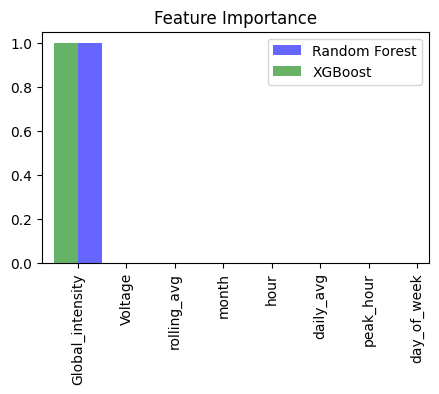

In [19]:
# Feature Importance for Tree-Based Models
plt.figure(figsize=(5, 3))
rf_importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
xgb_importances = pd.Series(best_xgb.feature_importances_, index=features).sort_values(ascending=False)
rf_importances.plot(kind='bar', color='blue', alpha=0.6, label='Random Forest', position=0)
xgb_importances.plot(kind='bar', color='green', alpha=0.6, label='XGBoost', position=1)
plt.title('Feature Importance')
plt.legend()
plt.show()
